Epoch 1, Average Loss: 190.3858
Epoch 2, Average Loss: 167.9240
Epoch 3, Average Loss: 163.3153
Epoch 4, Average Loss: 160.9048
Epoch 5, Average Loss: 159.2297
Epoch 6, Average Loss: 157.9295
Epoch 7, Average Loss: 156.9966
Epoch 8, Average Loss: 156.0722
Epoch 9, Average Loss: 155.2382
Epoch 10, Average Loss: 154.5743


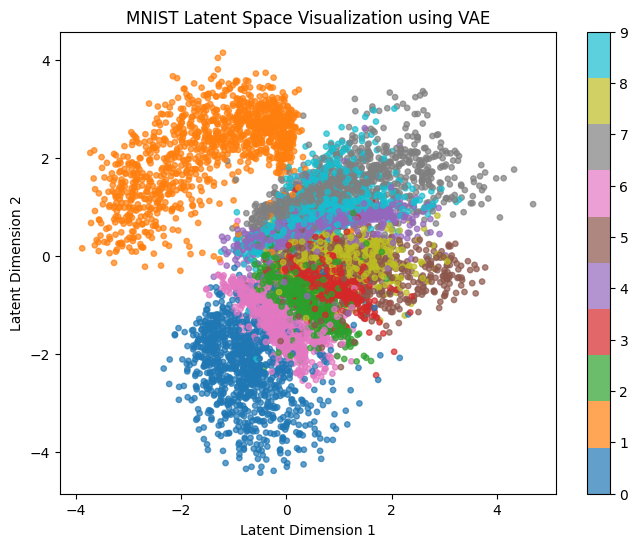

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load MNIST dataset
batch_size = 128
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)  # Mean
        logvar = self.fc22(h1)  # Log variance
        return mu, logvar

    # https://gregorygundersen.com/blog/2018/04/29/reparameterization/
    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Sample z

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        x_recon = self.sigmoid(self.fc4(h3))
        return x_recon

    def forward(self, x):
        # Forward pass
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 28 * 28), reduction="sum"
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # "mps"
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    average_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")

# Encode test images and collect latent representations
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = mu  # Use the mean as the representation
        z = z.cpu().numpy()
        labels = labels.numpy()
        z_list.append(z)
        labels_list.append(labels)

z_all = np.concatenate(z_list)
labels_all = np.concatenate(labels_list)

# Plot the latent space representations
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    z_all[:, 0], z_all[:, 1], c=labels_all, cmap="tab10", alpha=0.7, s=15
)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("MNIST Latent Space Visualization using VAE")
plt.show()

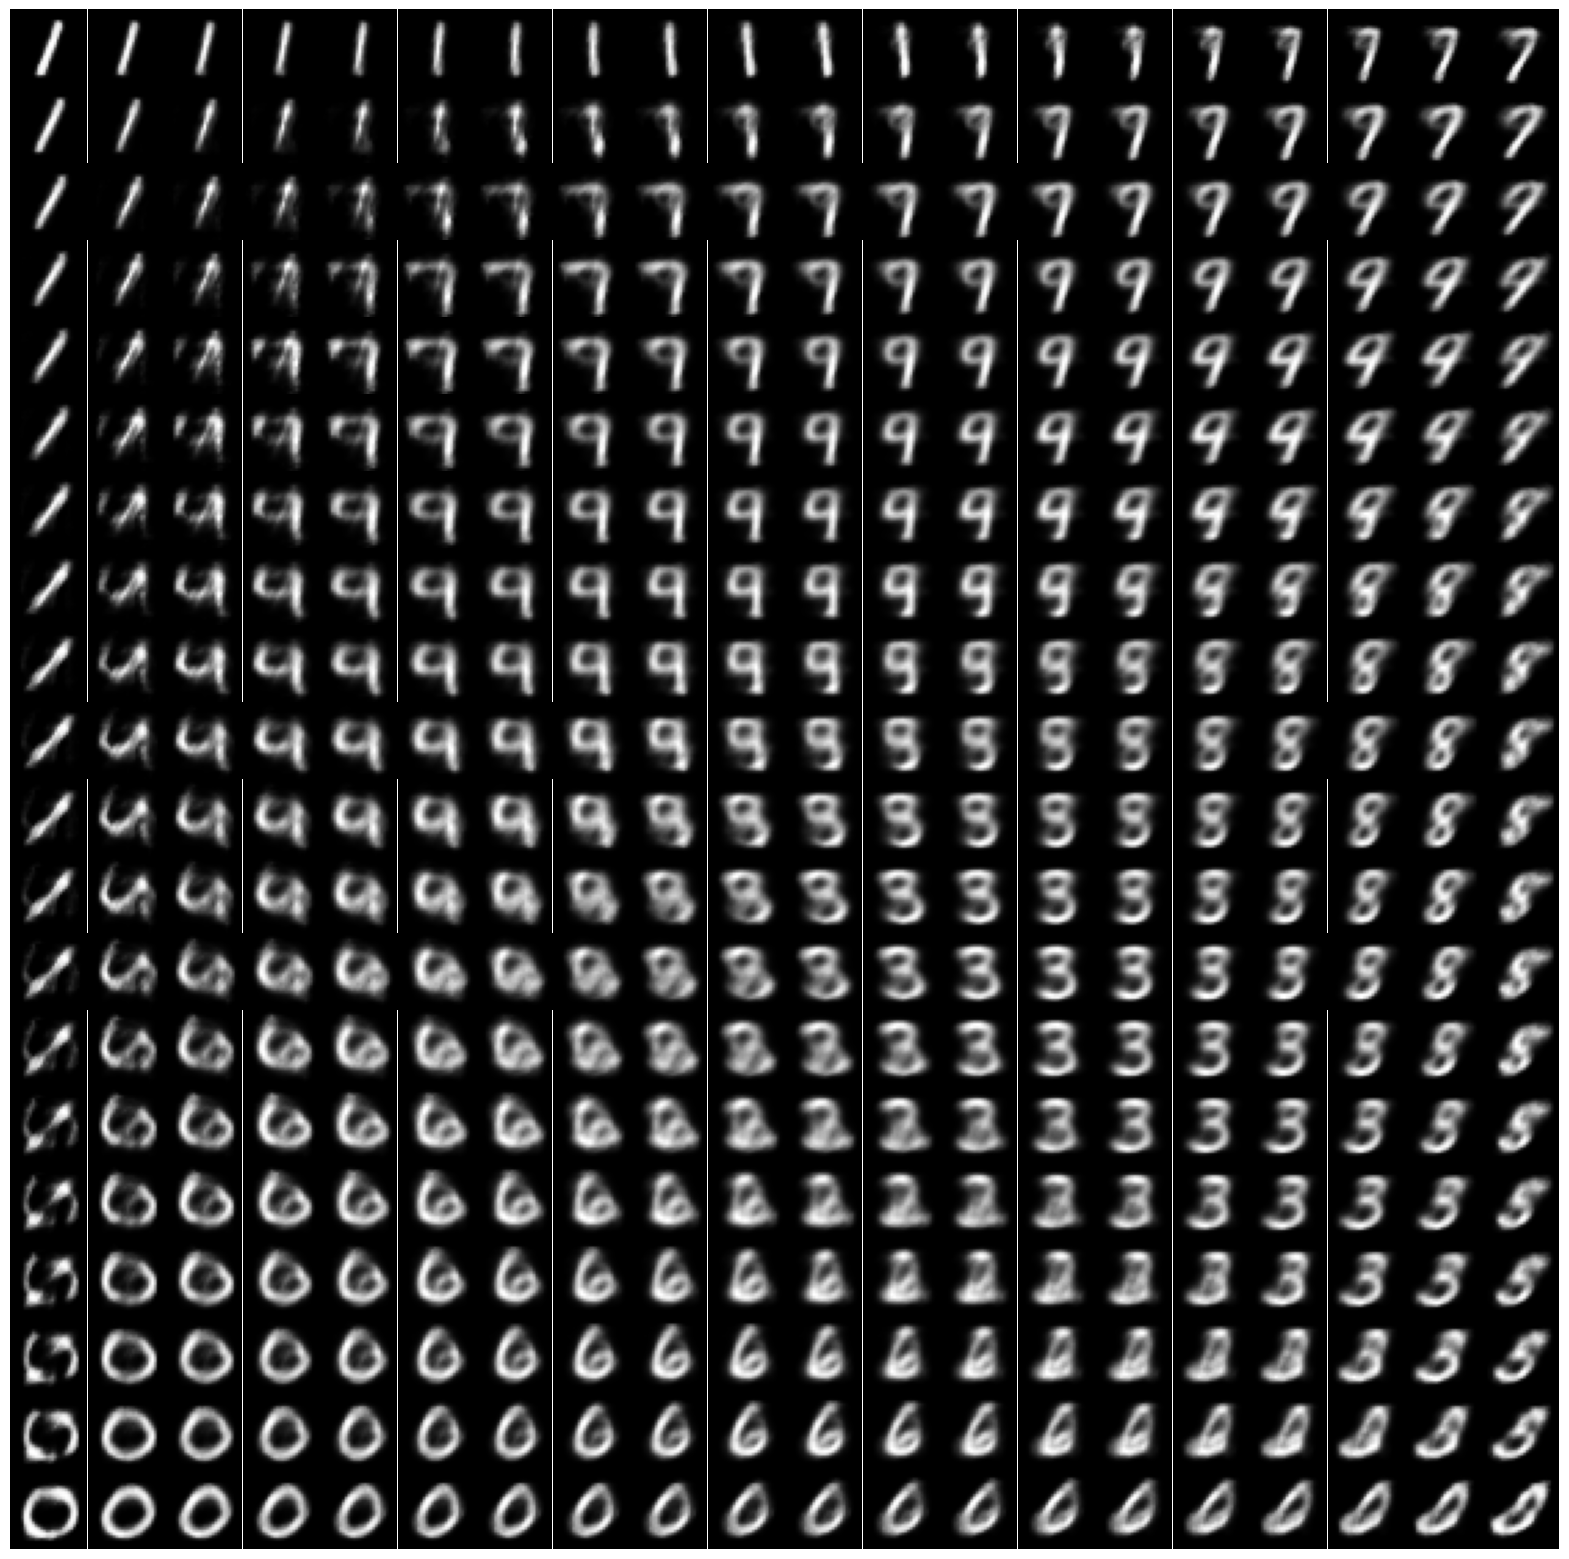

In [3]:
# Define the grid size
k = 20  # Number of points along each dimension

# Create a grid of uniformly spaced values in the range (0.01, 0.99)
grid_x = torch.linspace(0.01, 0.99, k)
grid_y = torch.linspace(0.01, 0.99, k)
mesh_x, mesh_y = torch.meshgrid(
    grid_x, grid_y, indexing="xy"
)  # Ensure correct axis indexing

# Stack the grid coordinates into a shape (k*k, 2)
coords = torch.stack([mesh_x, mesh_y], dim=-1).view(-1, 2)

# Map the uniformly distributed samples to the standard normal distribution using the inverse CDF
normal = torch.distributions.normal.Normal(0, 1)
z = normal.icdf(coords)  # Shape: (k*k, 2)

# Ensure the model is in evaluation mode
model.eval()

# Move the grid points to the same device as the model
z = z.to(device)

with torch.no_grad():
    # Decode the latent variables to generate images
    recon_x = model.decode(z).cpu()  # Shape: (k*k, 28*28)

# Reshape the reconstructed images for visualization
images = recon_x.view(-1, 1, 28, 28)  # Shape: (k*k, 1, 28, 28)

# Convert images to NumPy array for plotting
images = images.numpy()

# Create a figure with a grid of subplots
fig, axes = plt.subplots(k, k, figsize=(k, k))

for i in range(k):
    for j in range(k):
        idx = i * k + j  # Index of the current image
        # Reverse the order of rows to have the lowest latent y-values at the bottom
        ax = axes[k - i - 1, j]
        ax.imshow(images[idx, 0, :, :], cmap="gray")
        ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()